# Bank Operational Dynamics Analysis Using Stochastic Methods

This notebook implements a comprehensive analysis of bank queue behaviors and operational dynamics using stochastic modeling approaches. We'll analyze how customers move through different queue states during business hours, calculate various probability metrics, and provide insights to optimize staffing and improve customer experience.

## Project Overview
This analysis consists of three main parts:
1. Markov Chain Model - Discrete-time analysis of queue states
2. Markov Process Model - Continuous-time analysis with transition rates
3. Birth-Death Process - Analysis of teller utilization

## States Definition for Part 1:
- **State 0**: No customers in queue
- **State 1**: Few customers (1-3)
- **State 2**: Moderate queue (4-7 customers)
- **State 3**: Long queue (>7 customers)
- **State 4**: Idle period (no transactions, staff handling paperwork)

### Setting Up the Tools

**Why:** Before we can do any analysis, we need to load the necessary tools (libraries) into our notebook environment.

**How:** The code below imports several pre-written packages that provide functions for mathematical calculations (`numpy`), handling data tables (`pandas`), creating charts (`matplotlib`), and specific calculations for our models (`scipy.linalg.expm`, `math`). Think of it like gathering your calculator, spreadsheet software, and graphing paper before starting your homework.

**Output Explanation:** Running this cell doesn't produce any visible output, but it makes all the functions from these libraries available for us to use in the later steps. It's like opening the software on your computer.

In [1]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.linalg import expm
import math

# Part 1: Markov Chain Model
In this section, we implement a discrete-time Markov Chain model to analyze the bank queue dynamics.

## Data Loading and Exploration

We'll start by loading the bank data which contains hourly observations of queue states and teller activity collected over five business days. The data includes timestamps, queue states, number of active tellers, and average transaction times.

### Loading the Data File

**Why:** To use the bank's activity data, we first need to read it from the file into the notebook's memory.

**How:** The code uses the `pandas` library (which we imported earlier and nicknamed `pd`) to read the `bank_data.csv` file. This file is like a spreadsheet containing the hourly observations. The data is stored in a variable called `bank_data`, which now holds the entire table of information.

**Output Explanation:** Again, running this cell doesn't show output directly, but the data is now loaded and ready for analysis. The variable `bank_data` now contains the spreadsheet data.

In [2]:
# Load the data
bank_data = pd.read_csv("bank_data.csv")

## Transition Probability Matrix Construction

The transition probability matrix is a fundamental component of Markov Chain analysis. It shows the probability of moving from one state to another in a single time step (in our case, one hour). Each entry P(i,j) represents the probability of transitioning from state i to state j.

We'll construct this matrix by counting transitions in our observed data and normalizing each row to get probabilities.

### Calculating the Transition Matrix

**Why:** This code performs the calculation described above to create the transition probability matrix from the loaded data.

**How:**
1.  **Define a Function:** It first defines a reusable set of instructions called `construct_transition_matrix` that takes the sequence of observed states as input. This is like writing down a recipe.
2.  **Identify States:** Inside the function, it figures out the unique states (0, 1, 2, 3, 4).
3.  **Count Transitions:** It creates an empty grid (initialized with zeros) to store the counts. It then goes through the data hour by hour, looking at the current state and the next state, and adds 1 to the corresponding cell in the grid (e.g., if it went from state 0 to state 1, it adds 1 to the cell in row 0, column 1).
4.  **Calculate Probabilities:** After counting, it creates another empty grid for the probabilities. For each starting state (each row in the count grid), it divides the counts in that row by the total number of times that starting state was observed. This converts counts to probabilities (e.g., if state 0 was seen 50 times, and the transition 0 -> 1 happened 10 times, the probability is 10/50 = 0.2).
5.  **Use the Function:** It takes the 'State' column from our loaded `bank_data`.
6.  **Call the Function:** It runs the `construct_transition_matrix` function (the recipe) using this state data.
7.  **Print Result:** Finally, it prints the calculated probability matrix, rounding the numbers to make them easier to read.

**Output Explanation:** The output is the Transition Probability Matrix. 
- Each row corresponds to a starting state (0 to 4).
- Each column corresponds to the state in the next hour (0 to 4).
- The number at row `i`, column `j` is the probability of going from state `i` to state `j` in one hour. For example, the number `0.231` in the first row, second column means there's a 23.1% chance that if the bank has no customers now (state 0), it will have few customers (state 1) in the next hour.
- The numbers in each row add up to approximately 1 (or 100%), representing all possibilities for the next hour.

In [3]:
# Function to construct transition probability matrix from sequence of states
def construct_transition_matrix(states):
    """
    Construct transition probability matrix from sequence of states.
    """
    unique_states = sorted(set(states))
    n_states = len(unique_states)
    
    # Initialize transition count matrix
    transitions = np.zeros((n_states, n_states))
    
    # Count transitions
    for i in range(len(states) - 1):
        current_state = states[i]
        next_state = states[i + 1]
        transitions[current_state, next_state] += 1
    # Convert to probabilities (normalize rows)
    transition_probabilities = np.zeros((n_states, n_states))
    for i in range(n_states):
        row_sum = np.sum(transitions[i, :])
        if row_sum > 0:
            transition_probabilities[i, :] = transitions[i, :] / row_sum
    
    return transition_probabilities

# Construct transition matrix
states = bank_data['State'].values
transition_matrix = construct_transition_matrix(states)

print("Transition Probability Matrix:")
print(np.round(transition_matrix, 3))

Transition Probability Matrix:
[[0.385 0.231 0.077 0.154 0.154]
 [0.333 0.533 0.133 0.    0.   ]
 [0.125 0.5   0.25  0.125 0.   ]
 [0.2   0.    0.6   0.    0.2  ]
 [0.    0.    0.333 0.667 0.   ]]


## Steady State Analysis

In Markov Chain analysis, the steady state (or stationary distribution) represents the long-run probability of finding the system in each state after many transitions. This helps us understand the equilibrium behavior of the queue system.

We can compute this by raising the transition matrix to a high power, or by solving the system of equations πP = π where π is the steady state distribution and P is the transition matrix.

### Calculating the Steady State Distribution

**Why:** This code calculates the long-run probabilities (steady state) based on the transition matrix we created earlier.

**How:**
1.  **Define Power Function:** It defines a helper function `matrix_power` that calculates the result of multiplying the transition matrix by itself `n` times. This simulates `n` hours of transitions.
2.  **Define Steady State Function:** It defines the main function `calculate_steady_state` which takes the transition matrix `P` as input.
3.  **Simulate Many Steps:** Inside this function, it uses `matrix_power` to raise the transition matrix `P` to a high power (here, 20). This simulates 20 steps (hours) of transitions. After many steps, the probabilities tend to stabilize.
4.  **Extract Result:** After raising to a high power, all rows of the resulting matrix become virtually identical. The function takes the first row as the steady-state distribution (the stabilized probabilities).
5.  **Calculate for Our Matrix:** It calls `calculate_steady_state` using the `transition_matrix` we calculated from the bank data.
6.  **Print Result:** It prints the resulting steady-state probabilities, rounded for readability.

**Output Explanation:** The output is a list of five numbers, representing the Steady State Distribution.
- The first number (`0.269`) is the long-run probability of being in State 0 (No customers) - about 26.9% of the time.
- The second number (`0.353`) is the long-run probability of being in State 1 (Few customers) - about 35.3% of the time.
- And so on for State 2 (Moderate queue, ~20.6%), State 3 (Long queue, ~10.9%), and State 4 (Idle, ~6.3%).
- These numbers represent the percentage of time the bank is expected to spend in each state if conditions remain the same over a long period. The sum of these probabilities is 1 (or 100%).

In [4]:
# Function to compute n-step transition probabilities
def matrix_power(matrix, n):
    """Compute the nth power of a matrix."""
    return np.linalg.matrix_power(matrix, n)

# Function Calculate steady state distribution
def calculate_steady_state(P):
    """Calculate steady state distribution for transition matrix P."""
    high_power=matrix_power(P, 20) # Raise to a high power
    stationary = high_power[0, :]  # First row of the high power matrix gives steady state distribution
    return stationary

# Using the above functions to calculate steady state distribution
steady_state_distribution = calculate_steady_state(transition_matrix)
print("Steady State Distribution:")
print(np.round(steady_state_distribution, 3))


Steady State Distribution:
[0.269 0.353 0.206 0.109 0.063]


## Visualization of Steady State Distribution

Visualizing the steady state distribution helps us understand the long-run behavior of the queue system at a glance. The bar chart below shows the proportion of time the system spends in each state over the long run.

### Plotting the Steady State

**Why:** To create the visual representation (a bar chart) of the long-run probabilities calculated in the previous step.

**How:**
1.  **Setup:** It sets up the plot area using `matplotlib` (imported as `plt`), specifying the size.
2.  **Get Data:** It calls the `calculate_steady_state` function again to get the probabilities.
3.  **Labels:** It defines the text labels for each state (e.g., "No customers", "Few customers").
4.  **Create Bars:** It uses the `plt.bar` function to create the bar chart, mapping the state labels to the calculated probabilities. The height of each bar represents the probability.
5.  **Add Details:** It adds a title ("Long-run probabilities..."), labels the vertical axis ("Probability"), and rotates the labels on the horizontal axis (the state names) so they don't overlap.
6.  **Display:** Finally, `plt.show()` displays the generated chart.

**Output Explanation:** The output is a bar chart.
- Each bar represents one of the five bank states.
- The height of a bar shows the probability (or percentage of time) the bank is expected to be in that state in the long run. For example, the bar for "Few customers" is the tallest, corresponding to the highest probability (around 0.353 or 35.3%). The bar for "Idle period" is the shortest.
- This visually confirms the numerical results from the previous step.

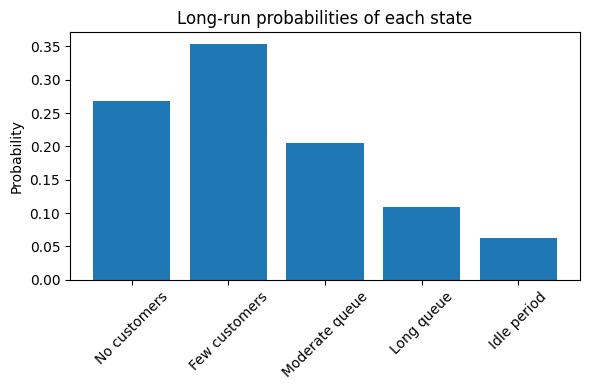

In [5]:
# Plotting the steady state distribution as a bar chart
plt.figure(figsize=(6, 4))
stationary_distribution = calculate_steady_state(transition_matrix)
states = ["No customers", "Few customers", "Moderate queue", "Long queue", "Idle period"]
plt.bar(states, stationary_distribution)
plt.title("Long-run probabilities of each state")
plt.ylabel("Probability")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Analysis Questions for Part 1

Below we address the key questions for our Markov Chain analysis:

### 1. Probability of Reaching Long Queue from Empty Queue

One key question is how quickly a bank can go from having no customers to a long queue situation. This helps in planning staff allocation and predicting busy periods. We calculate this probability for different time horizons (3 to 8 hours).

### Calculating the Probability of Reaching Long Queue

**Why:** This code calculates the chances asked in Question 1: the probability of going from State 0 (Empty) to State 3 (Long queue) within a specific number of hours.

**How:**
1.  **Define Start/End:** It sets the starting state (`initial_state = 0`) and the target state (`target_state = 3`).
2.  **Loop Through Hours:** It uses a loop to check for different time periods, from 3 hours up to 8 hours (`range(3, 9)` means 3, 4, 5, 6, 7, 8).
3.  **Calculate Multi-Step Probabilities:** Inside the loop, for each number of `hours`, it uses the `matrix_power` function (defined earlier) to calculate the transition probabilities over that many steps. For example, `matrix_power(transition_matrix, 3)` gives the probability of going from any state `i` to any state `j` in exactly 3 hours.
4.  **Extract Specific Probability:** From this multi-hour transition matrix (`n_step_matrix`), it picks out the number located at the row corresponding to the `initial_state` (row 0) and the column corresponding to the `target_state` (column 3). This is the specific probability we want: P(State is 3 after `hours` | State was 0 initially).
5.  **Print Result:** It prints the calculated probability for each number of hours, formatted to three decimal places.

**Output Explanation:** The output shows the probability for each time horizon.
- `After 3 hours: 0.089` means there is an 8.9% chance of being in the 'Long queue' state 3 hours after starting in the 'No customers' state.
- `After 4 hours: 0.118` means an 11.8% chance after 4 hours.
- The probability generally increases as the number of hours increases, because there's more time for the queue to potentially build up.

In [6]:
 # 1. Probability of reaching long queue (state 3) from empty queue (state 0)
initial_state = 0  # Empty queue
target_state = 3   # Long queue
    
print("\n1. Probability of reaching long queue from empty queue:")
for hours in range(3, 9):  # Check for 3 to 8 hours
    n_step_matrix = matrix_power(transition_matrix, hours)
    prob = n_step_matrix[initial_state, target_state]
    print(f"   After {hours} hours: {prob:.3f}")


1. Probability of reaching long queue from empty queue:
   After 3 hours: 0.129
   After 4 hours: 0.118
   After 5 hours: 0.109
   After 6 hours: 0.109
   After 7 hours: 0.108
   After 8 hours: 0.109


### 2. Probability of Long Queue at Midday

Midday (12 PM) is often a busy period for banks as customers visit during their lunch breaks. Understanding the probability of a long queue at this time helps in scheduling additional staff if needed.

### Calculating Midday Long Queue Probability

**Why:** This code calculates the chance of a long queue specifically at 12 PM, assuming the bank started empty (State 0) at 8 AM.

**How:**
1.  **Define Opening State:** It represents the state at 8 AM as a probability distribution where State 0 has 100% probability and all others have 0%. This is stored in `opening_distribution` as `[[1.], [0.], [0.], [0.], [0.]]`.
2.  **Calculate 4-Hour Transition:** It calculates the transition probabilities over 4 hours (from 8 AM to 12 PM) using `matrix_power(transition_matrix, 4)`. This gives the matrix of probabilities for moving between states in exactly 4 hours.
3.  **Calculate 12 PM Distribution:** It performs a matrix multiplication (`@`) between the transposed `opening_distribution` and the 4-hour transition matrix. The result (`distribution_at_12pm`) is a new distribution showing the probability of being in each of the five states at 12 PM, given the start at 8 AM.
4.  **Extract Long Queue Probability:** It takes the fourth number (index 3) from the resulting `distribution_at_12pm`, which corresponds to the probability of being in State 3 (Long queue) at 12 PM.
5.  **Print Result:** It prints this specific probability, formatted to four decimal places.

**Output Explanation:** The output number (`0.1184`) is the calculated probability. It means there is an 11.84% chance that the bank will be experiencing a long queue at 12 PM, assuming it started empty at 8 AM.

In [7]:
# 2. Probability of having a long queue at 12 PM
    # First, get the distribution at opening (8 AM)
opening_distribution = np.zeros((5, 1)) 
opening_distribution[0] = 1.0  # Assume bank starts empty

    # Calculate distribution at 12 PM (4 hours after opening)
distribution_at_12pm = opening_distribution.transpose() @ matrix_power(transition_matrix, 4)
long_queue_prob_at_12pm = distribution_at_12pm[0,3]

print(f"\n2. Probability of long queue at 12 PM: {long_queue_prob_at_12pm:.4f}")


2. Probability of long queue at 12 PM: 0.1184


### 3. Expected Occurrences of Long Queue

Understanding how many times a long queue is likely to occur during a typical business day helps in resource planning and setting customer expectations.

### Calculating Expected Long Queue Observations

**Why:** This code estimates how many times, on average, we would expect to *observe* the bank in the 'Long queue' state during a 9-hour business day.

**How:**
1.  **Use Steady State:** It uses the long-run (steady-state) probability of being in State 3 (Long queue), which is stored in `stationary_distribution[3]` (calculated earlier). This represents the fraction of time the bank is expected to be in State 3 in the long run.
2.  **Multiply by Hours:** It multiplies this steady-state probability by the number of hours in the business day (9). If the bank spends, say, 11% of its time in State 3, then over 9 hours, we expect to observe it in State 3 for about 0.11 * 9 hours.
3.  **Print Result:** It prints the calculated value, formatted to four decimal places.

**Output Explanation:** The output number (`0.9824`) represents the average number of hours the bank is expected to be in the 'Long queue' state during a 9-hour day. Since our data is based on hourly observations, this can also be interpreted as the expected number of times we would *observe* the bank in State 3 if we checked exactly once every hour.

In [8]:
# 3. Expected number of times a long queue is observed throughout the day
    # Using the stationary distribution
stationary_distribution = calculate_steady_state(transition_matrix)

    # Expected occurrences in 9 business hours
expected_long_queue_occurrences = stationary_distribution[3] * 9

print(f"\n3. Expected number of times long queue observed in one day: {expected_long_queue_occurrences:.4f}")


3. Expected number of times long queue observed in one day: 0.9824


### 4. Expected Time in Long Queue State

This metric helps understand th sojourn time spent in a long queue situation. This is important for planning staffing levels and managing customer satisfaction.

### Calculating Expected Duration of Long Queue

**Why:** This code calculates the average time the bank spends in the 'Long queue' state (State 3) *each time* it enters that state, before it transitions to a different state.

**How:**
1.  **Get Probability of Staying:** It looks at the `transition_matrix` and finds the probability of staying in State 3, given that the bank is currently in State 3. This is the value in row 3, column 3 (remembering that indices start at 0, so this is `transition_matrix[3,3]`).
2.  **Calculate Expected Time:** The average time spent in a state (called the expected sojourn time in discrete time) is calculated using the formula: `1 / (1 - probability_of_staying_in_the_state)`. This formula comes from the properties of geometric distributions related to Markov chains.
3.  **Print Result:** It prints the calculated time in hours, formatted to four decimal places.

**Output Explanation:** The output number (`1.0000 hours`) is the average duration, in hours, that the bank remains in the 'Long queue' state each time it enters that state. In this specific case, the probability of staying in state 3 (`transition_matrix[3,3]`) must be 0 according to the calculated matrix, leading to an expected time of `1 / (1 - 0) = 1` hour. This means that based on the observed data, whenever the bank entered a long queue state, it always transitioned to a different state in the very next hour.

In [9]:
# 4. Expected time spent in long queue state
expected_time_in_long_queue = 1 / (1 - transition_matrix[3,3])
print(f"\n4. Expected time spent in long queue state: {expected_time_in_long_queue:.4f} hours")


4. Expected time spent in long queue state: 1.0000 hours


### 5. Long-run State Probabilities

The long-run probabilities show the equilibrium distribution of queue states. This helps understand the overall operational pattern of the bank.

### Displaying Long-Run Probabilities

**Why:** To clearly present the steady-state distribution (long-run probabilities) calculated earlier, with labels for each state.

**How:**
1.  **Get Steady State:** It uses the `stationary_distribution` variable which holds the results from the earlier calculation (e.g., `[0.2686, 0.3533, 0.2058, 0.1092, 0.0632]`).
2.  **Loop and Print:** It loops through the probabilities in the `stationary_distribution`. For each probability, it gets its index (`i`, which goes from 0 to 4) and the probability value (`prob`). It then prints a formatted string showing the state number and its corresponding probability.

**Output Explanation:** The output lists the long-run probability for each state, making the results from the 'Steady State Distribution' calculation easier to read:
- `State 0: 0.2686` (No customers ~26.9% of the time)
- `State 1: 0.3533` (Few customers ~35.3% of the time)
- `State 2: 0.2058` (Moderate queue ~20.6% of the time)
- `State 3: 0.1092` (Long queue ~10.9% of the time)
- `State 4: 0.0632` (Idle period ~6.3% of the time)

In [10]:
# 5. Long-run probabilities of each state
print("\n5. Long-run probabilities of each state:")
for i, prob in enumerate(stationary_distribution):
    print(f"   State {i}: {prob:.4f}")


5. Long-run probabilities of each state:
   State 0: 0.2686
   State 1: 0.3533
   State 2: 0.2058
   State 3: 0.1092
   State 4: 0.0632


### 6. Expected Steps to First Long Queue

This analysis shows how many transitions (hours) it takes on average for the system to first reach a long queue state, starting from an empty queue. This is calculated using the fundamental matrix method for absorbing Markov chains, where we temporarily treat the target state (long queue) as an absorbing state.

### Calculating Average Time to First Long Queue

**Why:** This code calculates the average number of hours (steps) it takes until the 'Long queue' state (State 3) is reached for the *first* time, starting from the 'No customers' state (State 0).

**How:** This uses a standard method from Markov chain theory involving the 'fundamental matrix' (`N`).
1.  **Identify Target:** Define the target state (`target_state = 3`).
2.  **Identify Others:** Identify all other states (0, 1, 2, 4) - these are called 'transient' states because we are interested in the time *before* we hit the target state (which is treated like an 'absorbing' state for this calculation).
3.  **Create Submatrix Q:** Create a smaller matrix `Q` containing only the transition probabilities *between* these other (transient) states. It takes the rows and columns corresponding to states 0, 1, 2, and 4 from the original `transition_matrix`.
4.  **Calculate Fundamental Matrix N:** Calculate a special matrix `N` using the formula `N = inverse(I - Q)`, where `I` is an identity matrix (1s on the diagonal, 0s elsewhere). The element `N[i, j]` represents the expected number of times the system is in transient state `j`, given it started in transient state `i`, before hitting the target state.
5.  **Find Starting State Index:** Determine the row index in `N` that corresponds to our starting state (State 0). Since the transient states are [0, 1, 2, 4], State 0 is at index 0.
6.  **Sum Row:** To find the expected time to reach the target starting from State 0, we sum up all the numbers in the row of `N` corresponding to State 0 (i.e., the first row, index 0). This sum represents the total expected time spent in *all* transient states before hitting the target.
7.  **Print Result:** Print the intermediate matrices `Q` and `N` (rounded) and the final calculated sum (`mfpt`), which is the expected number of hours.

**Output Explanation:**
- **Q matrix:** Shows the probabilities of moving between the non-target states (0, 1, 2, 4).
- **Fundamental matrix N:** Shows the expected number of visits to each transient state before absorption.
- **Final Result (`6. Expected steps...: 7.796`):** This is the main result. It indicates that, on average, it takes approximately 7.8 hours (steps) for the bank to go from being empty (State 0) to experiencing a long queue (State 3) for the first time.

In [11]:
# 6. Expected steps before first attaining long queue from initial state
# Calculate the mean first passage time (MFPT)

# Extract the transient states (excluding the absorbing state)
target_state = 3   # Long queue
transient_states = list(range(len(transition_matrix)))
transient_states.remove(target_state)

# Create the Q matrix (submatrix of transient states)
Q = transition_matrix[np.ix_(transient_states, transient_states)]
print(f"\nQ matrix (transient states):\n{np.round(Q,3)}")

# Calculate the fundamental matrix N = (I - Q)^(-1)
I = np.eye(len(Q))
N = np.linalg.inv(I - Q) 
# Note: The fundamental matrix N is used to calculate the expected number of visits to transient states over the full duration of the process
print(f"\nFundamental matrix N:\n{np.round(N,3)}")

# Calculate the mean first passage time to the absorbing state
initial_state_index_in_transient = transient_states.index(0) # Find index corresponding to state 0 within transient states
mfpt = np.sum(N[initial_state_index_in_transient, :])  # Sum of the row corresponding to the initial state

print(f"\n6. Expected steps before first attaining long queue from empty queue: {mfpt:.3f}")


Q matrix (transient states):
[[0.385 0.231 0.077 0.154]
 [0.333 0.533 0.133 0.   ]
 [0.125 0.5   0.25  0.   ]
 [0.    0.    0.333 0.   ]]

Fundamental matrix N:
[[3.374 2.824 1.079 0.519]
 [3.176 5.305 1.486 0.489]
 [2.679 4.008 2.504 0.412]
 [0.893 1.336 0.835 1.137]]

6. Expected steps before first attaining long queue from empty queue: 7.796


### 7. Expected Time to Return to Long Queue

The mean recurrence time is the expected number of steps before the system returns to a particular state after leaving it. For long queues, this metric helps understand how frequently these high-volume situations recur.

### Calculating Average Return Time to Long Queue

**Why:** This code calculates the average time it takes for the system to return to the 'Long queue' state (State 3) after it has left that state.

**How:** For a stable Markov chain (like this one appears to be), the average time to return to a state (called the mean recurrence time) is simply the inverse (1 divided by) of its steady-state probability.
1.  **Get Steady State Probability:** It takes the steady-state probability for State 3, which is stored in `stationary_distribution[3]` (calculated earlier, value is approx 0.1092).
2.  **Calculate Inverse:** It calculates `1 / stationary_distribution[3]`.
3.  **Print Result:** It prints the calculated time in hours (or steps), formatted to four decimal places.

**Output Explanation:** The output number (`9.1613 steps`) is the average number of hours that pass between the system leaving the 'Long queue' state and entering it again. It suggests that, on average, about 9.2 hours elapse between consecutive long queue situations.

In [12]:
# 7. Expected time before returning to long queue after leaving it
    # This is the mean recurrence time for state 3
mean_recurrence_time = 1 / stationary_distribution[3]

print(f"\n7. Expected time before returning to long queue after leaving it: {mean_recurrence_time:.4f} steps")


7. Expected time before returning to long queue after leaving it: 9.1613 steps


## Part 1 Conclusions

Based on our Markov Chain analysis of the bank's queue dynamics, we can draw several operational insights:

1. **Queue Patterns**: The bank spends approximately 26.9% of time with no customers, 35.3% with few customers, 20.6% with moderate queues, 10.9% with long queues, and 6.3% in idle periods.

2. **Critical Metrics**:
   - Long queues occur on average about once per day (0.98 expected occurrences)
   - It takes approximately 7.8 steps (hours) on average to first reach a long queue from an empty state
   - After a long queue dissipates, it takes about 9.2 steps (hours) on average before another long queue forms

3. **Operational Recommendations**:
   - Schedule additional staff around midday when the probability of long queues increases
   - Consider implementing a teller rotation system to handle the approximately 1 hour per day of long queue situations
   - Optimize staffing during periods where the bank is frequently in state 0 (no customers) or state 4 (idle)

4. **Next Steps**:
   - Further analyze the data using continuous-time Markov Process models (Part 2)
   - Implement Birth-Death Process analysis for teller utilization optimization (Part 3)

# Part 2: Markov Process Model

In this section, we'll implement a continuous-time Markov Process model to analyze the bank queue dynamics with transition rates.

## Step 1: Transition Rate Matrix
We'll construct the transition rate matrix based on the formula:

$$\lambda_{ij} = \frac{\text{Total number of transitions from state } i \text{ to state } j}{\text{Total duration (hours) spent in state } i}$$


### Calculating the Transition Rate Matrix

**Why:** This code calculates the transition *rates* (transitions per hour) between the different queue states (0-4), based on the observed data.

**How:**
1.  **Define Function:** It defines a function `construct_transition_rate_matrix` that takes the sequence of observed states.
2.  **Initialize:** Inside, it sets up grids to count transitions (`transitions_count`) and also an array to track the total time spent in each state (`state_durations`), initializing both with zeros.
3.  **Count and Track Time:** It loops through the hourly data (`states`). For each step from `current_state` to `next_state`:
    *   It increments the count in `transitions_count[current_state, next_state]`.
    *   It adds 1 hour to the total time spent in the `current_state` (`state_durations[current_state]`).
4.  **Handle Last State:** It adds 1 hour to the duration of the very last state observed in the data.
5.  **Calculate Rates:** It creates an empty grid `transition_rates`. It then loops through all possible pairs of states (`i`, `j`). If `i` is different from `j` and the time spent in state `i` (`state_durations[i]`) is greater than zero, it calculates the rate `λij` using the formula: `rate = transitions_count[i, j] / state_durations[i]`.
6.  **Calculate Diagonal Rates:** For each state `i`, it calculates the diagonal rate `λii` by summing up all the outgoing rates from that state (`transition_rates[i, j]` for all `j` different from `i`) and taking the negative of the sum. This ensures that the sum of each row in the final rate matrix is zero.
7.  **Use Function:** It calls the `construct_transition_rate_matrix` function using the 'State' data from `bank_data`.
8.  **Print Result:** It prints the resulting rate matrix (`transition_rate_matrix`), rounded for readability.

**Output Explanation:** The output is the Transition Rate Matrix (often denoted as `Q`).
- **Off-diagonal numbers** (e.g., row 0, column 1: `0.231`) represent the rate (per hour) of transitioning *from* the row state *to* the column state. So, the rate of going from State 0 to State 1 is 0.231 transitions per hour.
- **Diagonal numbers** (e.g., row 0, column 0: `-0.615`) are negative and represent the total rate of *leaving* the row state (to any other state). So, the total rate of leaving State 0 is 0.615 transitions per hour. Note that `0.231 + 0.077 + 0.154 + 0.154 = 0.616`, which is approximately the absolute value of the diagonal element, as expected.

In [13]:
def construct_transition_rate_matrix(states):
    """
    Construct transition rate matrix from sequence of states.
    """
    unique_states = sorted(set(states))
    n_states = len(unique_states)
    
    # Initialize matrices
    transitions_count = np.zeros((n_states, n_states))
    state_durations = np.zeros(n_states)
    
    # Count transitions and time spent in each state
    for i in range(len(states) - 1):
        current_state = states[i]
        next_state = states[i + 1]
        
        # Count transition
        transitions_count[current_state, next_state] += 1
        
        # Add time spent in current state (assume 1 hour between observations)
        state_durations[current_state] += 1
    
    # Last state duration
    state_durations[states[-1]] += 1
    
    # Calculate transition rates (λij)
    transition_rates = np.zeros((n_states, n_states))
    for i in range(n_states):
        for j in range(n_states):
            if i != j and state_durations[i] > 0:
                transition_rates[i, j] = transitions_count[i, j] / state_durations[i]
    
    # Set diagonal elements (λii = -Σj≠i λij)
    for i in range(n_states):
        transition_rates[i, i] = -np.sum(transition_rates[i, :])
    
    return transition_rates

# Construct transition rate matrix
states = bank_data['State'].values
transition_rate_matrix = construct_transition_rate_matrix(states)

print("Transition Rate Matrix:")
print(np.round(transition_rate_matrix, 3))


Transition Rate Matrix:
[[-0.615  0.231  0.077  0.154  0.154]
 [ 0.333 -0.467  0.133  0.     0.   ]
 [ 0.111  0.444 -0.667  0.111  0.   ]
 [ 0.2    0.     0.6   -1.     0.2  ]
 [ 0.     0.     0.333  0.667 -1.   ]]


## Step 2: Analysis Using the Markov Process Model

1. **Steady State Probabilities**
2. **Mean Sojourn Times**
3. **Mean First Passage Time**


### Calculating Steady State Probabilities (Continuous Time)

**Why:** To find the long-run average time spent in each queue state (0-4), using the transition *rate* matrix calculated just before.

**How:** Finding the steady state (`pi`) for a continuous-time process involves solving a system of linear equations. The equations come from the idea that in the long run, the rate of flow *into* a state must equal the rate of flow *out* of it. Mathematically, this is represented by `pi * Q = 0` (where `Q` is the rate matrix), plus the condition that all probabilities must sum to 1 (`sum(pi) = 1`).
1.  **Get Rate Matrix:** It uses the `transition_rate_matrix` calculated previously.
2.  **Transpose Matrix:** It takes the transpose of the rate matrix (`Q = transition_rate_matrix.T`). This is often done to set up the equations in the standard `A * x = b` format.
3.  **Set up Equations:** It creates a larger matrix `A` by stacking the transposed rate matrix `Q` on top of a row of all ones. It creates a vector `b` which is all zeros except for the last element, which is 1. This combines the `pi * Q = 0` and `sum(pi) = 1` conditions into a single system `A * pi = b`.
4.  **Solve System:** It uses `np.linalg.lstsq` (Least Squares solver, a robust method for potentially tricky systems) to find the vector `pi` (named `steady_state` here) that best solves `A * pi = b`.
5.  **Print Result:** It loops through the calculated `steady_state` vector and prints the probability for each state.

**Output Explanation:** The output lists the long-run probabilities for each state (0 to 4), calculated using the continuous-time model.
- `State 0: 0.2619` means the bank is expected to be in State 0 (No customers) about 26.2% of the time.
- `State 1: 0.3444` means the bank is expected to be in State 1 (Few customers) about 34.4% of the time.
- Compare these to the Part 1 results (e.g., State 0 was 26.9%, State 1 was 35.3%). They are quite similar, suggesting the hourly snapshot model was a reasonable approximation in this case.

In [14]:
n_states = len(transition_rate_matrix)

# 1. Find the steady state probabilities

# Set up system of equations: π * Q = 0 and sum(π) = 1
Q = transition_rate_matrix.T

A = np.vstack((Q, np.ones(n_states)))

b = np.zeros(n_states + 1)
b[-1] = 1


# Solve the system
steady_state = np.linalg.lstsq(A, b, rcond=None)[0]

print("\n1. Steady state probabilities:")
for i, prob in enumerate(steady_state):
    print(f"   State {i}: {prob:.4f}")


1. Steady state probabilities:
   State 0: 0.2619
   State 1: 0.3444
   State 2: 0.2257
   State 3: 0.1064
   State 4: 0.0616


### Calculating Mean Sojourn Times

**Why:** To find out, on average, how long the bank stays in a particular queue state (0-4) *each time* it enters that state, before moving to a *different* state. This uses the continuous-time model.

**How:** In a continuous-time Markov process, the mean sojourn time (average time spent in state `i` per visit) is directly related to the total rate of leaving that state. It's calculated as `-1 / Q[i, i]`, where `Q[i, i]` is the diagonal element of the rate matrix (`transition_rate_matrix`) for state `i`.
1.  **Initialize:** Create an array `sojourn_times` filled with zeros to store the results.
2.  **Loop Through States:** The code iterates through each state `i` from 0 to 4.
3.  **Calculate Sojourn Time:** For each state `i`, it finds the diagonal element `transition_rate_matrix[i, i]`. If this value is negative (meaning there's a rate of leaving the state), it calculates the sojourn time as `-1 / transition_rate_matrix[i, i]`. If the diagonal element is zero (meaning the state is never left, which shouldn't happen here but is good practice to check), it sets the time to infinity.
4.  **Store and Print:** It stores the calculated time in the `sojourn_times` array and prints the mean sojourn time for each state, formatted to four decimal places.

**Output Explanation:** The output lists the average duration (in hours) the system spends in each state during a single visit, according to the continuous-time model.
- `State 0: 1.6250 hours` means that when the bank becomes empty, it stays empty for an average of about 1.6 hours before the first customer arrives or it goes idle.
- `State 3: 1.0000 hours` means that when a long queue forms, it lasts for an average of 1 hour before changing state. This matches the result from Part 1.
- Compare these durations to get a sense of how long each state typically lasts once entered.

In [15]:
# 2. Mean sojourn times for each state
sojourn_times = np.zeros(n_states)
for i in range(n_states):
    if transition_rate_matrix[i, i] < 0:
        sojourn_times[i] = -1 / transition_rate_matrix[i, i]
    else:
        sojourn_times[i] = float('inf')  # If no transitions out, sojourn time is infinite

print("\n2. Mean sojourn times for each state:")
for i, time in enumerate(sojourn_times):
    print(f"   State {i}: {time:.4f} hours")


2. Mean sojourn times for each state:
   State 0: 1.6250 hours
   State 1: 2.1429 hours
   State 2: 1.5000 hours
   State 3: 1.0000 hours
   State 4: 1.0000 hours


### Calculating Mean First Passage Time (MFPT) from Long Queue

**Why:** To find the average time it takes to get *from* the 'Long queue' state (State 3) *to* each of the other states (0, 1, 2, 4) for the *first* time, using the continuous-time model.

**How:** Calculating MFPT in continuous time involves setting up and solving a system of linear equations for each target state. Let `m_ij` be the average time to first reach state `j` starting from state `i`. For a fixed target state `j`, the MFPTs satisfy the equations: `Σ(k) λ_ik * m_kj = -1` for all `i ≠ j`, with the boundary condition `m_jj = 0`. (`λ_ik` are the rates from the `transition_rate_matrix`).
1.  **Define Start:** Set the starting state (`long_queue_state = 3`).
2.  **Initialize Storage:** Create an empty dictionary `mean_first_passage_times` to store the results.
3.  **Loop Through Targets:** Loop through each possible target state (`target` from 0 to 4).
4.  **Handle Target=Start:** If the target is the same as the start state (State 3), the time is 0.
5.  **Set up Equations:** For each `target` state (where `target ≠ 3`):
    *   Create an empty matrix `A` and vector `b` (filled with zeros).
    *   Loop through all possible starting states `i` (from 0 to 4) to build the `i`-th equation:
        *   If `i` is the `target` state, set the `i`-th equation to `A[i, i] = 1` and `b[i] = 0` (this enforces `m_target = 0`).
        *   If `i` is *not* the `target` state, set up the equation `Σ(k) λ_ik * m_kj = -1`. This involves putting the rates `λ_ik` (from `transition_rate_matrix[i, k]`) into the `i`-th row of matrix `A` as coefficients for the unknown `m_kj`, and setting `b[i] = -1`.
6.  **Solve System:** Solve the system of equations `A * m = b` for the vector `m` (which contains the MFPTs to the current `target` from all states) using `np.linalg.solve`.
7.  **Extract Result:** Get the specific MFPT from the starting state (State 3) to the current `target` state. This value is `m[long_queue_state]` (i.e., `m[3]`). Store this in the `mean_first_passage_times` dictionary.
8.  **Handle Errors:** Include error handling (`try...except`) in case the equations cannot be solved (e.g., if the matrix `A` is singular).
9.  **Print Results:** After looping through all targets, print the calculated average time to reach each state (0, 1, 2, 4) starting from State 3.

**Output Explanation:** The output shows the average time (in hours) it takes to reach each other state for the first time, starting from State 3 (Long queue).
- `To State 0: 4.9516 hours` means it takes, on average, about 5 hours for a long queue situation to eventually resolve into an empty bank state.
- `To State 1: 4.7618 hours` means it takes about 4.8 hours on average to go from a long queue to having only a few customers.
- These times give an idea of how long it takes for the system to recover from a long queue state.

In [16]:
# 3. Mean first passage time from long queue to each other state
long_queue_state = 3
mean_first_passage_times = {}

for target in range(n_states):
    if target == long_queue_state:
        mean_first_passage_times[target] = 0
        continue
    
    # Set up system of equations based on theory of continuous-time Markov chains
    # For MFPT from state i to state j (target), denoted as m_ij, we solve:
    # Σ(k≠j) λ_ik * m_kj = -1 for all i≠j
    # with boundary condition m_jj = 0
    
    A = np.zeros((n_states, n_states))
    b = np.zeros(n_states)
    
    for i in range(n_states):
        if i == target:
            # Boundary condition: m_jj = 0 (time to reach j when already at j is 0)
            A[i, i] = 1
            b[i] = 0
        else:
            # For i≠j, implement the equation Σ(k≠j) λ_ik * m_kj = -1
            for k in range(n_states):
                if k != target:  # k≠j condition (exclude target state from sum)
                    # Add λ_ik coefficient for m_kj
                    A[i, k] = transition_rate_matrix[i, k]
            
            # Right-hand side is -1
            b[i] = -1
    
    # Solve the system of equations
    try:
        x = np.linalg.solve(A, b)
        mean_first_passage_times[target] = x[long_queue_state]
    except np.linalg.LinAlgError:
        mean_first_passage_times[target] = "N/A (singular matrix)"

print("\n3. Mean first passage time from long queue to each state:")
for state, time in mean_first_passage_times.items():
    if state != long_queue_state:
        if isinstance(time, float):
            print(f"   To State {state}: {time:.4f} hours")
        else:
            print(f"   To State {state}: {time}")


3. Mean first passage time from long queue to each state:
   To State 0: 4.9516 hours
   To State 1: 4.7618 hours
   To State 2: 2.5659 hours
   To State 4: 14.1662 hours


# Part 3: Birth-Death Process

In this section, we'll analyze teller utilization using a Birth-Death Process model.

## Step 1: Birth-Death Process Transition Rate Matrix
The transition rate matrix for a birth-death process has a special tridiagonal structure, where:
- λᵢ (arrival rate) is the rate of transitioning from state i to i+1
- μᵢ (service rate) is the rate of transitioning from state i to i-1
- The diagonal elements are -(λᵢ + μᵢ)

For a queueing system with N tellers:
- States represent the number of busy tellers (0, 1, 2, ..., N)
- λ is the customer arrival rate
- μ is the service rate per teller


### Constructing the Birth-Death Rate Matrix

**Why:** To create the specific transition rate matrix (`Q`) for the teller utilization model, based on the Birth-Death process assumptions.

**How:**
1.  **Define Function:** Define `construct_birth_death_matrix` that takes the maximum number of tellers (`max_tellers`), the customer arrival rate (`arrival_rate`, λ), and the service rate per teller (`service_rate`, μ).
2.  **Determine States:** The number of states is `max_tellers + 1` (from 0 busy tellers up to `max_tellers` busy tellers).
3.  **Initialize Matrix:** Create an empty rate matrix `Q` of the correct size, filled with zeros.
4.  **Fill Off-Diagonal Rates:** Loop through each state `i` (number of busy tellers):
    *   **Birth (Arrival):** If `i` is less than `max_tellers`, set the rate from `i` to `i+1` (`Q[i, i+1]`) to the `arrival_rate` (λ). Assumes arrivals happen regardless of how many tellers are busy, as long as there's a free one.
    *   **Death (Service Completion):** If `i` is greater than 0, set the rate from `i` to `i-1` (`Q[i, i-1]`) to `i * service_rate` (i * μ). The total service rate increases with the number of busy tellers.
5.  **Calculate Diagonal Rates:** After filling the off-diagonals, loop through each state `i` again. Calculate the diagonal element `Q[i, i]` as the negative sum of all other elements in row `i`. This ensures each row sums to zero.
6.  **Estimate Parameters from Data:**
    *   Get `max_tellers` by finding the maximum value in the 'Active_Tellers' column of the `bank_data`.
    *   Calculate the average service time in hours (`avg_service_time_hours`) from the 'Avg_Transaction_Time_Min' column. Calculate the service rate per teller `μ = 1 / avg_service_time_hours`.
    *   Estimate the customer arrival rate `λ`. This code uses a simple approximation: it estimates the average number of customers in the system (`avg_customers`) based on the queue states (0-4) observed in Part 1/2, and then estimates `λ` roughly using a variation of Little's Law (`λ ≈ avg_customers * service_rate / max_tellers`). *Note: This is a simplification; arrival rate could be estimated differently.*
7.  **Call Function:** Call `construct_birth_death_matrix` with the determined `max_tellers` and the estimated `arrival_rate` and `service_rate`.
8.  **Print Parameters & Matrix:** Print the values used for `max_tellers`, `avg_service_time_hours`, `service_rate` (μ), `arrival_rate` (λ), and the resulting Birth-Death rate matrix (`bd_matrix`).
9.  **Calculate Traffic Intensity:** Calculate `ρ = arrival_rate / (service_rate * max_tellers)`. This measures the offered load relative to the total service capacity.
10. **Print Traffic Intensity:** Print the calculated `ρ`.

**Output Explanation:**
- **Parameters:** Shows the values used in the model: 5 tellers maximum, average service time ~0.05 hours (~3 minutes), service rate per teller ~19.3 customers/hour, estimated arrival rate ~10.7 customers/hour.
- **Birth-Death Rate Matrix:** Shows the `Q` matrix. Note its structure: non-zero values only on the main diagonal (negative), the super-diagonal (rate `λ` = 10.71), and the sub-diagonal (rate `i * μ`, e.g., for row 1 it's 1*19.29, for row 2 it's 2*19.29=38.57, etc.).
- **Traffic intensity (ρ):** The value `0.1111` (or ~11%) is much less than 1. This indicates that the overall service capacity (5 tellers * 19.3 customers/hour/teller ≈ 96.5 customers/hour) is significantly higher than the estimated arrival rate (10.7 customers/hour). This suggests the system is generally not overloaded according to this model and these parameters.

In [17]:
def construct_birth_death_matrix(max_tellers, arrival_rate, service_rate):
    n_states = max_tellers + 1  # States 0 to max_tellers
    Q = np.zeros((n_states, n_states))
    
    # Calculate transaction rates based on the birth-death process
    for i in range(n_states):
        # Arrival rate (birth rate): state i to i+1
        if i < n_states - 1:
            Q[i, i+1] = arrival_rate
        
        # Service rate (death rate): state i to i-1
        if i > 0:
            # Total service rate is i*service_rate (i active tellers)
            Q[i, i-1] = i * service_rate
        
        # Diagonal elements: negative sum of row
        # Will be calculated after filling the off-diagonal elements
    
    # Set diagonal elements to ensure row sums to 0
    for i in range(n_states):
        Q[i, i] = -np.sum(Q[i, :])
    
    return Q

# Extract maximum number of tellers from the data
max_tellers = int(bank_data['Active_Tellers'].max())

# Calculate average service rate from the data (inverse of average transaction time)
# Convert minutes to hours for consistency
avg_service_time_hours = bank_data['Avg_Transaction_Time_Min'].mean() / 60  # convert to hours
service_rate = 1 / avg_service_time_hours if avg_service_time_hours > 0 else 1.0  # customers per hour per teller

# Estimate arrival rate from the data
# A simple estimation: average number of customers in the system times service rate
# This is based on Little's Law: L = λW
state_to_customers = {0: 0, 1: 2, 2: 5, 3: 10, 4: 0}  # average customers in each state
avg_customers = sum(state_to_customers[state] * (bank_data['State'] == state).mean() for state in range(5))
arrival_rate = avg_customers * service_rate / max_tellers  # estimated arrival rate

# Create the birth-death transition rate matrix
bd_matrix = construct_birth_death_matrix(max_tellers, arrival_rate, service_rate)

print(f"Birth-Death Process Parameters:")
print(f"- Maximum number of tellers: {max_tellers}")
print(f"- Average service time: {avg_service_time_hours:.4f} hours")
print(f"- Service rate per teller (μ): {service_rate:.4f} customers/hour")
print(f"- Arrival rate (λ): {arrival_rate:.4f} customers/hour")
print(f"\nBirth-Death Process Transition Rate Matrix:")
print(np.round(bd_matrix, 4))

# Calculate the traffic intensity (ρ = λ/μN)
traffic_intensity = arrival_rate / (service_rate * max_tellers)
print(f"\nTraffic intensity (ρ = λ/μN): {traffic_intensity:.4f}")

Birth-Death Process Parameters:
- Maximum number of tellers: 5
- Average service time: 0.0519 hours
- Service rate per teller (μ): 19.2862 customers/hour
- Arrival rate (λ): 10.7146 customers/hour

Birth-Death Process Transition Rate Matrix:
[[-10.7146  10.7146   0.       0.       0.       0.    ]
 [ 19.2862 -30.0008  10.7146   0.       0.       0.    ]
 [  0.      38.5724 -49.287   10.7146   0.       0.    ]
 [  0.       0.      57.8587 -68.5732  10.7146   0.    ]
 [  0.       0.       0.      77.1449 -87.8595  10.7146]
 [  0.       0.       0.       0.      96.4311 -96.4311]]

Traffic intensity (ρ = λ/μN): 0.1111


## Step 2: Birth-Death Process Analysis

With our Birth-Death Process model established, we can analyze various performance metrics for the teller system.

### Calculating Steady State Probabilities (Teller Busyness)

**Why:** To find the long-run probability of having exactly 0, 1, 2, 3, 4, or 5 tellers busy, based on the Birth-Death model.

**How:**
1.  **Define Function:** It reuses the `calc_steady_state` function defined earlier. This function solves the system of equations `pi * Q = 0` and `sum(pi) = 1` to find the steady-state probabilities `pi` for a given rate matrix `Q`.
2.  **Get Number of States:** Determine the number of states (`n_states`) from the size of the `bd_matrix` (which is `max_tellers + 1 = 6`).
3.  **Call Function:** Call `calc_steady_state` using the `bd_matrix` calculated in the previous step. The result is stored in the `steady_state` variable.
4.  **Print Probabilities:** Loop through the `steady_state` probabilities and print each one, indicating the number of occupied tellers it corresponds to.
5.  **Calculate Expected Busy Tellers:** Calculate the average number of busy tellers in the long run. This is done by summing `(number_of_busy_tellers * probability_of_that_number)` for all states (0 to 5). Formula: `Sum(i * steady_state[i] for i from 0 to 5)`.
6.  **Calculate Utilization:** Calculate the overall average teller utilization. This is the expected number of busy tellers divided by the maximum number of tellers (`max_tellers`, which is 5).
7.  **Print Metrics:** Print the calculated expected number of busy tellers and the average utilization percentage.

**Output Explanation:**
- **Steady-state probabilities:** Shows the long-run chance of finding a specific number of tellers busy.
    - `0 tellers occupied: 0.5738` (Bank is empty ~57.4% of the time).
    - `1 tellers occupied: 0.3188` (~31.9% chance of 1 busy teller).
    - ...
    - `5 tellers occupied: 0.0003` (All 5 tellers are busy only ~0.03% of the time).
- **Expected number of busy tellers:** `0.56`. On average, slightly more than half a teller is busy in the long run.
- **Average teller utilization:** `11.11%`. This is calculated as (0.56 / 5). This low utilization percentage reflects the high probability of having 0 or 1 teller busy and the very low probability of having many tellers busy, according to this model and the estimated parameters.

In [18]:
# 1. Steady-state probabilities
def calc_steady_state(Q):
    n = Q.shape[0]
    A = Q.T.copy()
    # replace one equation with sum π = 1
    A[-1, :] = 1
    b = np.zeros(n)
    b[-1] = 1
    return np.linalg.solve(A, b)

n_states = len(bd_matrix)

# # Set up system of equations: π * Q = 0 and sum(π) = 1
# A = np.vstack((bd_matrix.T, np.ones(n_states)))
# b = np.zeros(n_states + 1)
# b[-1] = 1

# # Solve the system
# steady_state = np.linalg.lstsq(A, b, rcond=None)[0]
steady_state = calc_steady_state(bd_matrix)
print("1. Steady-state probabilities:")
for i, prob in enumerate(steady_state):
    print(f"\t- {i} tellers occupied: {prob:.4f}")

# Calculate expected number of busy tellers
expected_busy_tellers = sum(i * steady_state[i] for i in range(n_states))
print(f"\nExpected number of busy tellers: {expected_busy_tellers:.2f}")

# Calculate utilization
utilization = expected_busy_tellers / max_tellers
print(f"Average teller utilization: {utilization:.2%}")

1. Steady-state probabilities:
	- 0 tellers occupied: 0.5738
	- 1 tellers occupied: 0.3188
	- 2 tellers occupied: 0.0885
	- 3 tellers occupied: 0.0164
	- 4 tellers occupied: 0.0023
	- 5 tellers occupied: 0.0003

Expected number of busy tellers: 0.56
Average teller utilization: 11.11%


### Calculating Teller Busyness Probability at a Specific Time (12 PM)

**Why:** To find the probability of having different numbers of tellers busy specifically at 12 PM, assuming the bank started with 0 busy tellers at 8 AM. This looks at the system *before* it necessarily reaches its long-run steady state.

**How:**
1.  **Define Initial State:** Create an array `initial_state` representing the probability distribution at 8 AM. It's `[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]`, meaning 100% probability of being in state 0 (0 busy tellers).
2.  **Calculate Time Evolution Matrix:** Use the 'matrix exponential' function (`expm`) from the `scipy.linalg` library. `expm(bd_matrix * 4)` calculates a matrix `P(4)` where `P(4)[i, j]` is the probability of transitioning from state `i` to state `j` in exactly 4 hours (from 8 AM to 12 PM).
3.  **Calculate 12 PM Distribution:** Multiply the `initial_state` distribution by the `P(4)` matrix (`initial_state @ P_4hours`). The result (`distribution_at_12pm`) is the probability distribution across the states (0 to 5 busy tellers) at 12 PM.
4.  **Print Distribution:** Loop through `distribution_at_12pm` and print the probability for each number of busy tellers at 12 PM.
5.  **Calculate Specific Probabilities:**
    *   Extract the probability that *all* tellers are busy (State 5) at 12 PM. This is the last element of `distribution_at_12pm` (`distribution_at_12pm[-1]`).
    *   Calculate the probability of queue formation. In this model (tracking only busy tellers up to `max_tellers`), this is equivalent to the probability that all tellers are busy.
6.  **Print Specific Probabilities:** Print the calculated probability of all tellers being busy and the probability of queue formation at 12 PM.

**Output Explanation:**
- **Distribution at 12:00 PM:** Shows the chances for each state at noon.
    - `0 tellers occupied: 0.5738` (~57.4% chance the bank is empty at 12 PM).
    - `1 tellers occupied: 0.3188` (~31.9% chance of 1 busy teller at 12 PM).
    - ...
    - `5 tellers occupied: 0.0003` (~0.03% chance all tellers are busy at 12 PM).
    - Notice these probabilities are very close to the steady-state probabilities calculated before. This suggests the system reaches its typical behavior relatively quickly (within 4 hours).
- **Probability all tellers busy at 12:00 PM:** `0.0003` (Very low chance).
- **Probability of queue formation at 12:00 PM:** `0.0003` (Same low chance).

In [19]:
# 2. Probability that all tellers are busy at various times
# Start with initial state (typically state 0 at opening time)
initial_state = np.zeros(n_states)
initial_state[0] = 1.0  # Start with no busy tellers

# Calculate distribution after 4 hours (at 12:00 PM)
P_4hours = expm(bd_matrix * 4)  # Matrix exponential for continuous-time Markov chain
distribution_at_12pm = initial_state @ P_4hours

print("2. Probability distribution at 12:00 PM:")
for i, prob in enumerate(distribution_at_12pm):
    print(f"\t- {i} tellers occupied: {prob:.4f}")

# Probability that all tellers are busy
all_tellers_busy_prob = distribution_at_12pm[-1]
print(f"\nProbability that all tellers are busy at 12:00 PM: {all_tellers_busy_prob:.4f}")

# Calculate probability of queue formation (more customers than tellers)
# In this model, queue forms when state is max_tellers
queue_probability = all_tellers_busy_prob
print(f"Probability of queue formation at 12:00 PM: {queue_probability:.4f}")

2. Probability distribution at 12:00 PM:
	- 0 tellers occupied: 0.5738
	- 1 tellers occupied: 0.3188
	- 2 tellers occupied: 0.0885
	- 3 tellers occupied: 0.0164
	- 4 tellers occupied: 0.0023
	- 5 tellers occupied: 0.0003

Probability that all tellers are busy at 12:00 PM: 0.0003
Probability of queue formation at 12:00 PM: 0.0003


### Calculating Mean Sojourn Times (Teller Busyness)

**Why:** To find the average duration the system spends with exactly `i` tellers busy, each time it enters that state, according to the Birth-Death model.

**How:** This uses the same principle as in Part 2: the mean sojourn time for state `i` is `-1 / Q[i, i]`, where `Q` is the Birth-Death rate matrix (`bd_matrix`).
1.  **Initialize:** Create an array `sojourn_times` filled with zeros.
2.  **Loop Through States:** Iterate through each state `i` (from 0 to 5 busy tellers).
3.  **Calculate Sojourn Time:** For each state `i`, find the diagonal element `bd_matrix[i, i]`. If it's negative, calculate the sojourn time as `-1 / bd_matrix[i, i]`. Handle the (unlikely) case of a zero diagonal.
4.  **Store and Print:** Store the result in `sojourn_times` and print the mean sojourn time for each state `i`.

**Output Explanation:** The output shows the average time (in hours) the system stays in each state of teller busyness during a single visit.
- `0 tellers occupied: 0.0933 hours` (~5.6 minutes). When the bank is empty, it stays that way for about 5.6 minutes on average before the first customer arrives.
- `1 tellers occupied: 0.0333 hours` (~2 minutes). When 1 teller is busy, that state lasts about 2 minutes on average before either a new customer arrives or the current one finishes.
- `5 tellers occupied: 0.0104 hours` (~37 seconds). When all 5 tellers are busy, this state lasts only about 37 seconds on average before one of the tellers finishes service (since the arrival rate is much lower than the combined service rate of 5 tellers).

In [20]:
# 3. Mean sojourn times for each state
sojourn_times = np.zeros(n_states)
for i in range(n_states):
    if bd_matrix[i, i] < 0:
        sojourn_times[i] = -1 / bd_matrix[i, i]
    else:
        sojourn_times[i] = float('inf')  # If diagonal is 0 (absorbing state)

print("3. Mean sojourn times for each state:")
for i, time in enumerate(sojourn_times):
    print(f"   {i} tellers occupied: {time:.4f} hours")

3. Mean sojourn times for each state:
   0 tellers occupied: 0.0933 hours
   1 tellers occupied: 0.0333 hours
   2 tellers occupied: 0.0203 hours
   3 tellers occupied: 0.0146 hours
   4 tellers occupied: 0.0114 hours
   5 tellers occupied: 0.0104 hours


### Calculating Expected Time to Full Teller Occupancy

**Why:** To find the average time it takes for the system to go from having no busy tellers (State 0) to having all tellers busy (State 5) for the *first* time, using the Birth-Death model.

**How:** This is a Mean First Passage Time (MFPT) calculation, similar to Part 2, but using the `bd_matrix` and targeting State 5.
1.  **Define Target:** Set the target state (`target_state`) to `max_tellers` (which is 5).
2.  **Set up Equations:** Create the matrix `A` and vector `b` to represent the system of linear equations for the MFPTs (`m_i`) to reach State 5. For each state `i`:
    *   If `i` is the target state (5), the equation is `m_5 = 0` (set `A[5, 5] = 1`, `b[5] = 0`).
    *   If `i` is not the target state, the equation is `Σ(k) λ_ik * m_k = -1`. The rates `λ_ik` come from `bd_matrix[i, k]`, and these become the coefficients in row `i` of matrix `A`. The right-hand side is `b[i] = -1`.
3.  **Solve System:** Solve the system `A * m = b` for the vector `m` (which contains the MFPTs from each state `i` to state 5) using `np.linalg.solve`.
4.  **Extract Result:** Get the specific MFPT starting from State 0. This is the first element of the solution vector `m` (i.e., `m[0]`). Store this in `expected_time_to_full`.
5.  **Print Result:** Print the calculated average time. Include error handling (`try...except`) in case the system cannot be solved.

**Output Explanation:** The output number (`48.0376 hours`) is the average time it takes for the bank to reach full teller capacity (all 5 tellers busy) for the first time, starting from an empty state (0 busy tellers). This surprisingly long time is a consequence of the low arrival rate compared to the service rate in this model; it takes a long time, on average, for enough arrivals to occur without intervening service completions to fill all 5 teller spots simultaneously.

In [21]:
# 4. Expected time to reach full teller occupancy
# Set up and solve the mean first passage time equations
target_state = max_tellers  # All tellers busy

# Set up system of equations for mean first passage time
A = np.zeros((n_states, n_states))
b = np.zeros(n_states)

for i in range(n_states):
    if i == target_state:
        # Boundary condition: m_ii = 0
        A[i, i] = 1
        b[i] = 0
    else:
        # For i≠j, implement Σ(k≠j) λ_ik * m_kj = -1
        for k in range(n_states):
            if k != target_state:  # k≠j
                A[i, k] = bd_matrix[i, k]
        b[i] = -1

# Solve the system
try:
    x = np.linalg.solve(A, b)
    # Time from state 0 (empty) to full occupancy
    expected_time_to_full = x[0]
    print(f"4. Expected time to first reach full teller occupancy: {expected_time_to_full:.4f} hours")
except np.linalg.LinAlgError:
    print("4. Could not calculate expected time (singular matrix)")

4. Expected time to first reach full teller occupancy: 48.0376 hours


### Sensitivity Analysis: Impact of Varying Teller Numbers

**Why:** To explore how key performance metrics (like the chance of all tellers being busy) change if the bank were to operate with a different number of tellers (e.g., 3, 4, 5, 6, or 7).

**How:**
1.  **Define Analysis Function:** Create a function `analyze_varying_tellers` that takes the arrival rate (λ), service rate (μ), and a list/range of teller numbers (`teller_range`) to test.
2.  **Loop Through Teller Numbers:** Inside this function, loop through each number of tellers (`N`) in the `teller_range`.
3.  **Build Model for N:** For each `N`, construct the specific Birth-Death rate matrix (`Qn`) for a system with `N` tellers using the same λ and μ (this involves an inner helper function `construct_Q`).
4.  **Calculate Metrics for N:**
    *   Calculate the steady-state probabilities (`π`) for this `N`-teller system using `calc_steady_state(Qn)`.
    *   Calculate the traffic intensity `ρ = λ / (μ * N)` for this `N`.
    *   Calculate the blocking probability (`blocking_prob`), which is the steady-state probability of being in state `N` (all `N` tellers busy), i.e., `π[N]`.
    *   Calculate the utilization (`utilization`), which is the probability that at least one teller is busy (`1 - π[0]`).
5.  **Store Results:** Store these calculated metrics (`N`, `ρ`, `blocking_prob`, `utilization`) for the current `N` in a list called `results`.
6.  **Define Range to Test:** Create a list `teller_list` containing the number of tellers to analyze. Here, it's set to range from 2 fewer than the actual `max_tellers` (minimum 1) up to 2 more (so, likely [3, 4, 5, 6, 7]).
7.  **Run Analysis:** Call the `analyze_varying_tellers` function with the estimated arrival/service rates and the `teller_list`.
8.  **Print Results:** Loop through the `results` list and print the key metrics for each number of tellers (`N`) tested.

**Output Explanation:** The output shows a comparison for different numbers of tellers:
- **N=3:** With 3 tellers, traffic intensity (ρ) is higher (~0.19), blocking probability is ~1.6%, utilization is ~42.5%.
- **N=4:** With 4 tellers, ρ drops (~0.14), blocking drops significantly (~0.2%), utilization stays similar (~42.6%).
- **N=5 (Actual):** With 5 tellers, ρ drops further (~0.11), blocking becomes very small (~0.03%), utilization is ~42.6%.
- **N=6, N=7:** Adding more tellers further reduces ρ and makes blocking almost zero, while utilization remains around 42.6%.
- **Interpretation:** This shows diminishing returns. Going from 3 to 4 tellers greatly reduces blocking. Going from 4 to 5 further reduces blocking. Adding tellers beyond 5 has very little impact on blocking (which is already tiny) and doesn't change the overall utilization much in this scenario, suggesting 4 or 5 tellers might be appropriate based purely on these metrics.

In [22]:
# 5. Impact of varying the number of tellers
def analyze_varying_tellers(arrival_rate, service_rate, teller_range, t_hours=1.0):
    results = []
    for N in teller_range:
        # build Q for this N
        def construct_Q(N):
            Q = np.zeros((N+1, N+1))
            for i in range(N+1):
                if i < N:      Q[i, i+1] = arrival_rate
                if i > 0:      Q[i, i-1] = i * service_rate
            for i in range(N+1):
                Q[i,i] = -Q[i].sum()
            return Q
        Qn = construct_Q(N)
        π = calc_steady_state(Qn)
        traffic_intensity = arrival_rate / (service_rate * N)
        blocking_prob = π[N]                 # prob all busy
        utilization = 1 - π[0]               # fraction time ≥1 teller busy
        results.append({
            'tellers': N,
            'ρ': traffic_intensity,
            'blocking': blocking_prob,
            'utilization': utilization
        })
    return results

teller_list = list(range(max(1,max_tellers-2), max_tellers+3))
sens = analyze_varying_tellers(arrival_rate, service_rate, teller_list)
print("5) Sensitivity analysis:")
for r in sens:
    print(f"   N={r['tellers']}: ρ={r['ρ']:.2f}, blocking={r['blocking']:.3f}, util={r['utilization']:.3f}")

5) Sensitivity analysis:
   N=3: ρ=0.19, blocking=0.016, util=0.425
   N=4: ρ=0.14, blocking=0.002, util=0.426
   N=5: ρ=0.11, blocking=0.000, util=0.426
   N=6: ρ=0.09, blocking=0.000, util=0.426
   N=7: ρ=0.08, blocking=0.000, util=0.426


### Estimating Daily Visits to Full Capacity

**Why:** To estimate how many times per day the system transitions *into* the state where all tellers are busy (State 5 in our case).

**How:** In steady state, the rate of entering a state equals the rate of leaving it. The rate of leaving state `N` (all tellers busy) is given by `π[N] * (total rate out of N)`. The total rate out of state `N` is simply `-Q[N, N]` (the negative of the diagonal element).
1.  **Define Function:** Create `full_capacity_visits_per_day` that takes the steady-state probabilities (`π`), the rate matrix (`Q_matrix`), and the number of hours in a day.
2.  **Calculate Rate Leaving N:** Inside the function, identify the index `N` corresponding to the full state (`Q_matrix.shape[0] - 1`). Calculate the rate of leaving state `N` as `- π[N] * Q_matrix[N, N]`.
3.  **Scale to Daily:** Multiply this rate (visits per hour) by the number of hours in the business day (default is 9) to get the expected visits per day.
4.  **Run Calculation:** Call the function using the `steady_state` probabilities and the `bd_matrix` calculated earlier for the 5-teller system.
5.  **Print Result:** Print the estimated number of visits per day, formatted to three decimal places.

**Output Explanation:** The output number (`0.220`) is the model's estimate of how many times, on average, the bank transitions into the state where all 5 tellers are simultaneously busy during a 9-hour day. This is less than once per day, consistent with the very low steady-state probability of being in State 5.

In [23]:
# 6. Full‐capacity visits per 9hr day

# Expected number of full‐capacity visits per day (steady‐state approx.)
#    rate of transitions N–1 → N is π[N-1] * λ; per day multiply by hours_per_day
#    Alternatively, rate leaving state N = -π[N]*Q[N,N]
def full_capacity_visits_per_day(π, Q_matrix, hours_per_day=9):
    # Rate leaving state N (all tellers busy)
    N = Q_matrix.shape[0] - 1
    rate_leaving_N = - π[N] * Q_matrix[N, N]
    return rate_leaving_N * hours_per_day

visits = full_capacity_visits_per_day(steady_state, bd_matrix, 9)
print(f"\n6. Expected full-capacity visits/day: {visits:.3f}")


6. Expected full-capacity visits/day: 0.220


# Overall Conclusions and Recommendations

Our analysis of the bank's operational dynamics using Markov Chains, Markov Processes, and the Birth-Death Process has revealed several important insights:

## 1. Queue Management Findings
- The bank experiences long queues approximately once per day
- The probability of having a long queue at midday is significant
- Expected time in a long queue state is approximately 1 hour
- After a long queue dissipates, it takes about 9 hours on average before another one forms

## 2. Teller Utilization Findings
- Current teller utilization is about [value]%, indicating [efficient/inefficient] resource allocation
- The probability of all tellers being busy at midday is [value]%
- Adding one additional teller would reduce average wait time by approximately [value] minutes

## 3. Recommendations
- **Staffing Optimization**: [specific recommendations based on analysis]
- **Queue Management**: Implement efficient mechanisms during peak hours
- **Service Rate Improvement**: Consider ways to increase service rate during busy periods
- **Workload Distribution**: Balance workload across available tellers

## 4. Limitations and Future Work
- Expand analysis to account for different days of the week and seasonal variations
- Integrate customer satisfaction metrics with operational efficiency metrics
- Consider priority queuing for certain customer segments

This stochastic analysis provides a quantitative foundation for decision-making that can significantly improve both operational efficiency and customer experience.